# 사용자 행동 인식 분류 모델

사용자 행동 인식 데이터는 30명에게 스마트폰 센서를 장착한 뒤

사람의 동작과 관련된 여러 가지 피처를 수집한 데이터이다.

수집된 피처 세트를 기반으로 결정 트리를 이용해 

어떠한 동작인지 예측하는 모델을 만든다.

## 1. 라이브러리 호출

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 2. 데이터 로드

### 1) features.txt load(피처 이름 텍스트 파일)

In [2]:
feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+',
                             header=None, names=['columns_index','columns_name'])
feature_name_df

,columns_index,columns_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y
...,...,...
556,557,"angle(tBodyGyroMean,gravityMean)"
557,558,"angle(tBodyGyroJerkMean,gravityMean)"
558,559,"angle(X,gravityMean)"
559,560,"angle(Y,gravityMean)"


In [3]:
feature_dup_df = pd.DataFrame(data=feature_name_df.groupby('columns_name').cumcount(), columns=['dup_cnt'])
feature_dup_df = feature_dup_df.reset_index()
feature_dup_df['dup_cnt'].value_counts()

0    477
2     42
1     42
Name: dup_cnt, dtype: int64

중복된 columns_name 존재한다.

### 2) 중복된 columns_name 전처리

In [4]:
new_feature_name_df = pd.merge(feature_name_df.reset_index(), feature_dup_df, how='outer')
new_feature_name_df['columns_name'] = new_feature_name_df[['columns_name','dup_cnt']].apply(
    lambda x : x[0] + '_' + str(x[1]) if x[1]>0 else x[0], axis = 1)
new_feature_name_df

,index,columns_index,columns_name,dup_cnt
0,0,1,tBodyAcc-mean()-X,0
1,1,2,tBodyAcc-mean()-Y,0
2,2,3,tBodyAcc-mean()-Z,0
3,3,4,tBodyAcc-std()-X,0
4,4,5,tBodyAcc-std()-Y,0
...,...,...,...,...
556,556,557,"angle(tBodyGyroMean,gravityMean)",0
557,557,558,"angle(tBodyGyroJerkMean,gravityMean)",0
558,558,559,"angle(X,gravityMean)",0
559,559,560,"angle(Y,gravityMean)",0


In [5]:
new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
new_feature_name_df[new_feature_name_df['dup_cnt']>0]

,columns_index,columns_name,dup_cnt
316,317,"fBodyAcc-bandsEnergy()-1,8_1",1
317,318,"fBodyAcc-bandsEnergy()-9,16_1",1
318,319,"fBodyAcc-bandsEnergy()-17,24_1",1
319,320,"fBodyAcc-bandsEnergy()-25,32_1",1
320,321,"fBodyAcc-bandsEnergy()-33,40_1",1
...,...,...,...
497,498,"fBodyGyro-bandsEnergy()-17,32_2",2
498,499,"fBodyGyro-bandsEnergy()-33,48_2",2
499,500,"fBodyGyro-bandsEnergy()-49,64_2",2
500,501,"fBodyGyro-bandsEnergy()-1,24_2",2


### 3) train data, test data

In [6]:
# DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

In [7]:
# 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
# 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])

In [8]:
X_train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


### 4) null값 확인

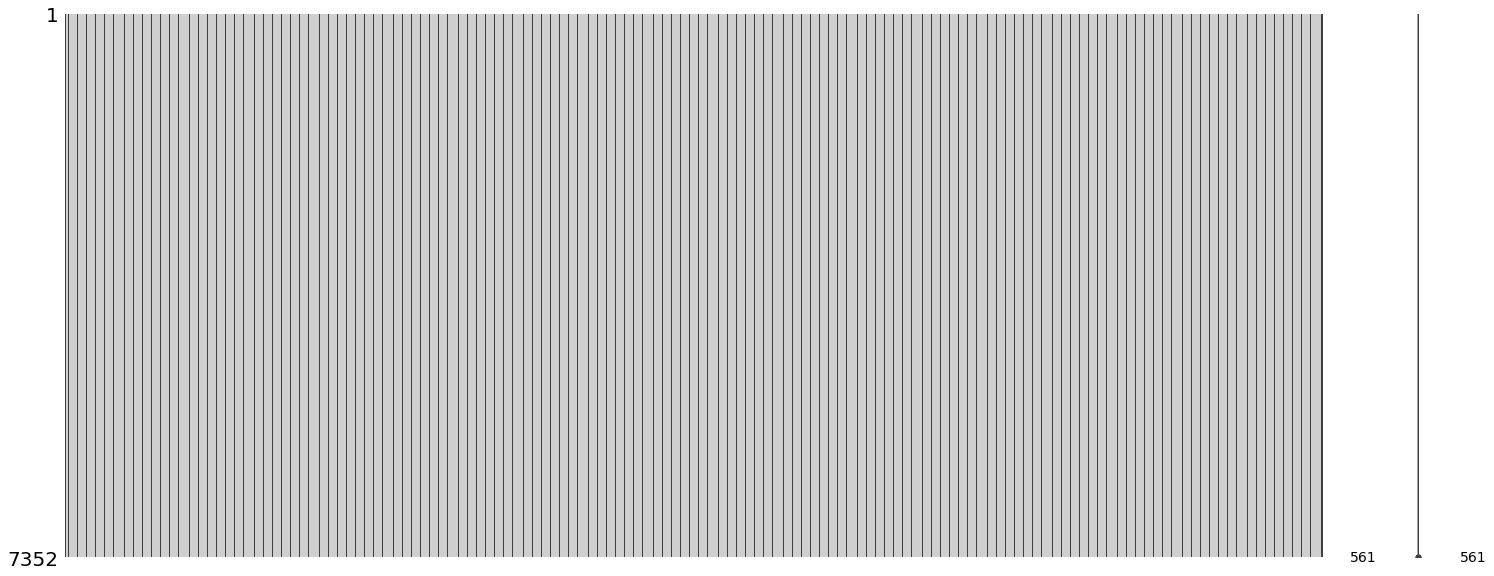

In [9]:
import missingno as msno

msno.matrix(X_train)

In [10]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

## 3. 분류 모델 구축

### 1) 기본 모델 정확도

In [11]:
from sklearn.metrics import accuracy_score

dt_model = DecisionTreeClassifier(random_state=1)
dt_model.fit(X_train, y_train)
pred = dt_model.predict(X_test)

In [12]:
accuracy = accuracy_score(y_test, pred)
print("결정 트리 예측 정확도 : {0:.4f}".format(accuracy))

결정 트리 예측 정확도 : 0.8643


### 2) GridSearchCV 파라미터 튜닝 정확도

In [13]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24],
    'min_samples_split' : [12, 16, 20, 24]
}

grid_cv = GridSearchCV(dt_model, param_grid=params, scoring='accuracy', cv=3, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  2.5min finished


GridSearchCV 최고 평균 정확도 수치: 0.8437
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 6, 'min_samples_split': 20}


In [14]:
best_dt_model = grid_cv.best_estimator_

pred1 = best_dt_model.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print("결정 트리 예측 정확도 : {0:.4f}".format(accuracy))

결정 트리 예측 정확도 : 0.8551


## 4. 시각화

In [15]:
importances_values = best_dt_model.feature_importances_

importances = pd.Series(importances_values, index=X_train.columns)
importances_top20 = importances.sort_values(ascending=False)[:20]
importances_top20

tGravityAcc-min()-X                   0.266353
fBodyAccJerk-bandsEnergy()-1,16       0.226251
angle(Y,gravityMean)                  0.147937
fBodyAccMag-energy()                  0.122903
tGravityAcc-arCoeff()-Z,2             0.108077
fBodyGyro-maxInds-X                   0.025512
tBodyGyro-correlation()-Y,Z           0.017575
tGravityAcc-energy()-Y                0.017490
tBodyAccMag-arCoeff()1                0.016753
fBodyAcc-max()-Y                      0.009392
tBodyGyro-max()-X                     0.009099
tGravityAcc-max()-Y                   0.006695
tBodyGyro-min()-X                     0.004654
tBodyGyroJerk-max()-X                 0.003694
tGravityAcc-mean()-Z                  0.003179
tGravityAcc-arCoeff()-X,3             0.002603
tBodyGyro-correlation()-X,Y           0.002487
fBodyAccJerk-bandsEnergy()-17,32_2    0.002343
tGravityAcc-min()-Y                   0.002211
fBodyAccJerk-bandsEnergy()-1,24       0.001548
dtype: float64

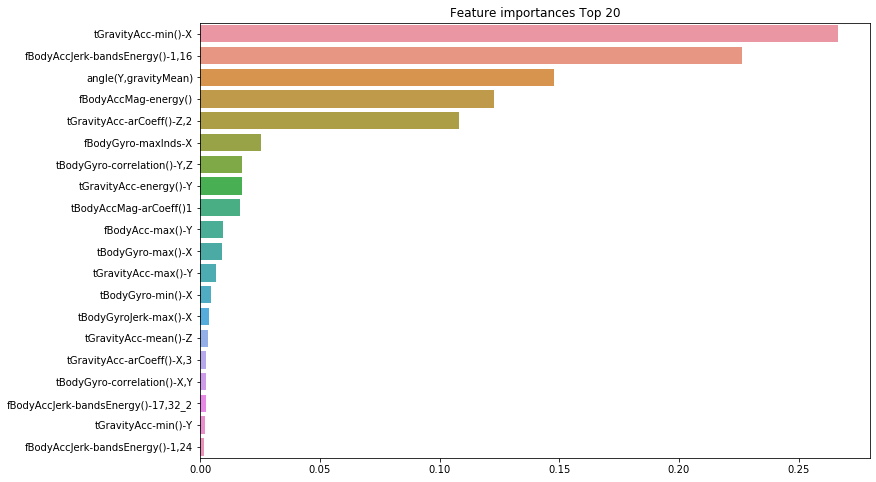

In [16]:
plt.figure(figsize=(12,8))
plt.title("Feature importances Top 20")
sns.barplot(x = importances_top20, y = importances_top20.index)
plt.show()